In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#"/content/drive/My Drive/Colab Notebooks/Model 2/"
#/content/drive/My Drive/Colab Notebooks/Model 2/layers
#
import sys

sys.path.insert(1, '/content/drive/My Drive/Colab Notebooks/Model 2/layers')
#print("1")
import attention
from attention import AttentionLayer

In [0]:
pip install BeautifulSoup4

In [0]:
import numpy as np
import pandas as pd 
import re
#from bs4 import BeautifulSoup4


from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Bidirectional ,Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
'''
'''
from os import listdir

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# split a document into news story and highlights
def split_story(doc):
	# find first highlight
	index = doc.find('@highlight')
	# split into story and highlights
	story, highlights = doc[:index], doc[index:].split('@highlight')
	# strip extra white space around each highlight
	highlights = [h.strip() for h in highlights if len(h) > 0]
	return story, highlights

# load all stories in a directory
def load_stories(directory):
	stories = list()
	for name in listdir(directory):
		filename = directory + '/' + name
		# load document
		doc = load_doc(filename)
		# split into story and highlights
		story, highlights = split_story(doc)
		# store
		stories.append({'story':story, 'highlights':highlights})
	return stories

# load stories   /content/drive/My Drive/Colab Notebooks/Model 2/stories10
directory ='/content/drive/My Drive/Colab Notebooks/Model 2/stories10' #'F:\cnn_stories\cnn\stories50'
stories = load_stories(directory)
print('Loaded Stories %d' % len(stories))

Loaded Stories 543


In [0]:
print(stories[0])
type(stories)
df3=pd.DataFrame(stories)
df3.head()

{'story': '(CNN)For the second time during his papacy, Pope Francis has announced a new group of bishops and archbishops set to become cardinals -- and they come from all over the world.\n\nPope Francis said Sunday that he would hold a meeting of cardinals on February 14 "during which I will name 15 new Cardinals who, coming from 13 countries from every continent, manifest the indissoluble links between the Church of Rome and the particular Churches present in the world," according to Vatican Radio.\n\nNew cardinals are always important because they set the tone in the church and also elect the next pope, CNN Senior Vatican Analyst John L. Allen said. They are sometimes referred to as the princes of the Catholic Church.\n\nThe new cardinals come from countries such as Ethiopia, New Zealand and Myanmar.\n\n"This is a pope who very much wants to reach out to people on the margins, and you clearly see that in this set," Allen said. "You\'re talking about cardinals from typically overlooke

,story,highlights
0,"(CNN)For the second time during his papacy, Pope Francis has announced a new group of bishops and archbishops set to become cardinals -- and they come from all over the world.\n\nPope Francis said...","[The 15 new cardinals will be installed on February 14, They come from countries such as Myanmar and Tonga, No Americans made the list this time or the previous time in Francis' papacy]"
1,"New Haven, Connecticut (CNN) -- A judge in New Haven sentenced a 31-year-old man to death Friday for his role in a deadly home invasion that killed a woman and her two daughters in 2007.\n\nJurors...","[A judge sentences Joshua Komisarjevsky to death, The 12-member jury voted for death by lethal injection on each of the six counts, Another man also has been sentenced to death in the case, A jury..."
2,"ATLANTA, Georgia (CNN) -- Dressed head to toe in black, designer Isaac Mizrahi is wearing an outfit that seems to contradict his personality -- and his usual fashion flair.\n\nIsaac Mizrahi has e...","[Designer Isaac Mizrahi moving from Target to creative director at Liz Claiborne, Mizrahi says he believes ""bad hair"" is the most common style mistake Designer says he prefers no flowers to ""bad""..."
3,"(CNN)Marco Rubio is all in. The Republican senator from Florida has announced that he is seeking the Republican presidential nomination, running on an optimistic message that he embodies the prom...","[Raul Reyes: In seeking Latino vote, Marco Rubio his own worst enemy on two key issues: immigration reform, Cuba relations, He says on health care, climate change and other issues, he breaks from ..."
4,"HAMILTON, Bermuda (CNN) -- Four Chinese nationals of Uyghur ethnicity who had been held at the U.S. military's Guantanamo Bay, Cuba, detention facility have been resettled in Bermuda, officials sa...","[NEW: Bermudan premier: ""Above all, this was a humanitarian act"", Uyghurs are native Chinese Muslims; the detainees were apprehended in Pakistan, China urges U.S. to hand over all 17 Uyghurs held ..."


In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

#******************************************

In [0]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    #newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

def text_cleanerlist(text,num):
    newString = [x.lower() for x in text]  # text.lower() #[x.lower() for x in d['highlights'][0]])
    #newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', str(newString))
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

print("step1")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
step1


In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

####In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

# Load Dataset

In [0]:
df= pd.DataFrame(stories)
(df.head())
#df.shape

,story,highlights
0,"(CNN)For the second time during his papacy, Pope Francis has announced a new group of bishops and archbishops set to become cardinals -- and they come from all over the world.\n\nPope Francis said...","[The 15 new cardinals will be installed on February 14, They come from countries such as Myanmar and Tonga, No Americans made the list this time or the previous time in Francis' papacy]"
1,"New Haven, Connecticut (CNN) -- A judge in New Haven sentenced a 31-year-old man to death Friday for his role in a deadly home invasion that killed a woman and her two daughters in 2007.\n\nJurors...","[A judge sentences Joshua Komisarjevsky to death, The 12-member jury voted for death by lethal injection on each of the six counts, Another man also has been sentenced to death in the case, A jury..."
2,"ATLANTA, Georgia (CNN) -- Dressed head to toe in black, designer Isaac Mizrahi is wearing an outfit that seems to contradict his personality -- and his usual fashion flair.\n\nIsaac Mizrahi has e...","[Designer Isaac Mizrahi moving from Target to creative director at Liz Claiborne, Mizrahi says he believes ""bad hair"" is the most common style mistake Designer says he prefers no flowers to ""bad""..."
3,"(CNN)Marco Rubio is all in. The Republican senator from Florida has announced that he is seeking the Republican presidential nomination, running on an optimistic message that he embodies the prom...","[Raul Reyes: In seeking Latino vote, Marco Rubio his own worst enemy on two key issues: immigration reform, Cuba relations, He says on health care, climate change and other issues, he breaks from ..."
4,"HAMILTON, Bermuda (CNN) -- Four Chinese nationals of Uyghur ethnicity who had been held at the U.S. military's Guantanamo Bay, Cuba, detention facility have been resettled in Bermuda, officials sa...","[NEW: Bermudan premier: ""Above all, this was a humanitarian act"", Uyghurs are native Chinese Muslims; the detainees were apprehended in Pakistan, China urges U.S. to hand over all 17 Uyghurs held ..."


In [0]:
highlights = " ".join([w for word in highlights])

In [0]:
# Create sentence and label lists
sentences = df.story.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

highlights = df.highlights.values    # highlights = label
highlights = ["[CLS] " + highlights + " [SEP]" for highlight in highlights]

TypeError: ignored

In [0]:
df['cleaned_summary'] =df['highlights'].apply(lambda x: text_cleanerlist(x,0))
df['cleaned_text'] =df['story'].apply(lambda x: text_cleaner(x,0))

#print(df.head())

print("step2")

# ********************************
import matplotlib.pyplot as plt
%matplotlib inline
text_word_count = []
summary_word_count = []

print("step2.1")
# populate the lists with sentence lengths
for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))


print("step2.2")

step2
step2.1
step2.2


In [0]:
df.head()

,story,highlights,cleaned_summary,cleaned_text
0,"(CNN)For the second time during his papacy, Pope Francis has announced a new group of bishops and archbishops set to become cardinals -- and they come from all over the world.\n\nPope Francis said...","[The 15 new cardinals will be installed on February 14, They come from countries such as Myanmar and Tonga, No Americans made the list this time or the previous time in Francis' papacy]",new cardinals installed february come countries myanmar tonga americans made list time previous time francis papacy,second time papacy pope francis announced new group bishops archbishops set become cardinals come world pope francis said sunday would hold meeting cardinals february name new cardinals coming cou...
1,"New Haven, Connecticut (CNN) -- A judge in New Haven sentenced a 31-year-old man to death Friday for his role in a deadly home invasion that killed a woman and her two daughters in 2007.\n\nJurors...","[A judge sentences Joshua Komisarjevsky to death, The 12-member jury voted for death by lethal injection on each of the six counts, Another man also has been sentenced to death in the case, A jury...",judge sentences joshua komisarjevsky death member jury voted death lethal injection six counts another man also sentenced death case jury convicted komisarjevsky october six felony charges,new connecticut judge new sentenced year old man death friday role deadly home invasion killed woman two daughters jurors convicted joshua komisarjevsky october six capital felony charges member j...
2,"ATLANTA, Georgia (CNN) -- Dressed head to toe in black, designer Isaac Mizrahi is wearing an outfit that seems to contradict his personality -- and his usual fashion flair.\n\nIsaac Mizrahi has e...","[Designer Isaac Mizrahi moving from Target to creative director at Liz Claiborne, Mizrahi says he believes ""bad hair"" is the most common style mistake Designer says he prefers no flowers to ""bad""...",designer isaac mizrahi moving target creative director liz claiborne mizrahi says believes bad hair common style mistake designer says prefers flowers bad ones mizrahi admits claustrophobic person...,atlanta georgia dressed head toe black designer isaac mizrahi wearing outfit seems contradict personality usual fashion flair isaac mizrahi earned four awards council fashion designers america alw...
3,"(CNN)Marco Rubio is all in. The Republican senator from Florida has announced that he is seeking the Republican presidential nomination, running on an optimistic message that he embodies the prom...","[Raul Reyes: In seeking Latino vote, Marco Rubio his own worst enemy on two key issues: immigration reform, Cuba relations, He says on health care, climate change and other issues, he breaks from ...",raul reyes seeking latino vote marco rubio worst enemy two key issues immigration reform cuba relations says health care climate change issues breaks latinos positions polls show favor,marco rubio republican senator florida announced seeking republican presidential nomination running optimistic message embodies promise american dream youthful energy hispanic roots tempting see r...
4,"HAMILTON, Bermuda (CNN) -- Four Chinese nationals of Uyghur ethnicity who had been held at the U.S. military's Guantanamo Bay, Cuba, detention facility have been resettled in Bermuda, officials sa...","[NEW: Bermudan premier: ""Above all, this was a humanitarian act"", Uyghurs are native Chinese Muslims; the detainees were apprehended in Pakistan, China urges U.S. to hand over all 17 Uyghurs held ...",new bermudan premier humanitarian act uyghurs native chinese muslims detainees apprehended pakistan china urges hand uyghurs held guantanamo bay cuba official says still negotiating palau take rem...,hamilton bermuda four chinese nationals uyghur ethnicity held military guantanamo bay cuba detention facility resettled bermuda officials said thursday attorney general eric holder says extremely ...


In [0]:
for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})


print("step2.3")


#length_df.hist(bins = 100)
print("step2.4")
#plt.show()

print("step3")

#*****************************************

step2.3
step2.4
step3


In [0]:
cnt=0
for i in df['cleaned_summary']:
    if(len(i.split())<=50):               # if it = 50 it will be 0.9999513168784382
        cnt=cnt+1
print(cnt/len(df['cleaned_summary']))


cnt=0
for i in df['cleaned_text']:
    if(len(i.split())<=800):               # if it = 50 it will be 0.9999513168784382
        cnt=cnt+1
print(cnt/len(df['cleaned_text']))

max_text_len=800
max_summary_len=50


cleaned_text =np.array(df['cleaned_text'])
cleaned_summary=np.array(df['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df1=pd.DataFrame({'text':short_text,'summary':short_summary})
#print(df1)       # 19997

df1['summary'] = df1['summary'].apply(lambda x : 'sostok '+ x + ' eostok')


print("step4")

1.0
0.9779005524861878
step4


In [0]:
############split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df1['text']),np.array(df1['summary']),test_size=0.1,random_state=0,shuffle=True)


#
print(len(x_tr))
print(len(x_val))
print(len(y_tr))
print(len(y_val))



print("step5")
#Text Tokenizer
# from tensorflow.keras.preprocessing.text import Tokenizer 
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# #prepare a tokenizer for reviews on training data
# x_tokenizer = Tokenizer() 
# x_tokenizer.fit_on_texts(list(x_tr))

# #############################################
for i in x_val:
  print(i)
  print("**************************")



477
54
477
54
step5
lane remorseless killer escaped ohio prison serving three life sentences school shooting captured six long hours police scoured neighborhoods north end lima ohio asking residents lock doors stay inside brought extra officers provided patrols families lane victims end found yards away outside church prison warden said say anything put fight authorities said lane serving consecutive life sentences without possibility parole attack chardon high school february walked school cafeteria caliber gun randomly started shooting fired rounds killing three students year old scaled fence allen oakwood correctional institution lima miles northwest columbus warden kevin jones said maximum security facility something sit take look lane escaped along two men thursday back custody shortly friday never plan someone escaping certainly someone notoriety would think would take special precautions prevent ian friedman represented trial said late thursday huge case ohio everyone ohio shock

#Install and Import
#####Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

Edit -> Notebook Settings -> Add accelerator (GPU)

Then run the following cell to confirm that the GPU is detected.

In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Import pytorch-pretrained-bert

In [0]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 3.4MB/s 
     |████████████████████████████████| 92kB 12.4MB/s 


In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


####In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

#Load Dataset

In [0]:
############split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df1['text']),np.array(df1['summary']),test_size=0.1,random_state=0,shuffle=True)


#
print(len(x_tr))
print(len(x_val))
print(len(y_tr))
print(len(y_val))



print("step5")
#Text Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

#############################################

477
54
477
54
step5


#Let us look at the proportion rare words and its total coverage in the entire text(storiers)

#Here, I am defining the threshold to be 4 which means word whose count is below 4 is considered as a rare word


In [0]:
thresh=8

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)
print("Total count of all vocabs :",tot_cnt)
print("the top most common words :",tot_cnt-cnt)
print("the words that num of words less than thresh :",cnt)


print("step6")

% of rare words in vocabulary: 80.037376012267
Total Coverage of rare words: 21.09260571698559
Total count of all vocabs : 20869
the top most common words : 4166
the words that num of words less than thresh : 16703
step6


#Let us define the tokenizer with top most common words for stories/

#prepare a tokenizer for reviews on training data

In [0]:
# ^^^^^^^^^^^^^^Let us define the tokenizer with top most common words for stories^^^^^^^^^^^^^^^
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print(x_voc)

#prepare a tokenizer for stories on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

#print(y_tokenizer.word_counts.items())

print("step7")


4167
step7


# **bold text** Rarewords and its Coverag **bold text**



In [0]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
#print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
#print("Total Coverage of rare words:",(freq/tot_freq)*100)
#
#print("the top most common words :",tot_cnt-cnt)
#print("the words that num of words less than thresh :",cnt)

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

#y_tokenizer.word_counts.items()

print(y_tokenizer.word_counts['sostok'],len(y_tr)) #17997
#y_tokenizer.word_counts['sostok'],len(y_tr)
print(y_tokenizer.word_counts['eostok'],len(y_tr))

print("step8")

477 477
477 477
step8


###                       Model building

In [0]:
from tensorflow.keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

print("step9")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
step9


### Define the model 

In [0]:

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

print("step10")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 800, 100)     416700      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 800, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy' , metrics=['accuracy'])

history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,batch_size=16 , validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))



print("yaarab lak alhamd")


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 477 samples, validate on 54 samples
Epoch 1/10
477/477 [==============================] - 117s 245ms/sample - loss: 1.8726 - acc: 0.7430 - val_loss: 1.3695 - val_acc: 0.8167
Epoch 2/10
477/477 [==============================] - 113s 237ms/sample - loss: 1.4061 - acc: 0.7739 - val_loss: 1.0546 - val_acc: 0.8193
Epoch 3/10
477/477 [==============================] - 114s 239ms/sample - loss: 1.3214 - acc: 0.7846 - val_loss: 1.0259 - val_acc: 0.8348
Epoch 4/10
477/477 [==============================] - 114s 238ms/sample - loss: 1.3104 - acc: 0.7910 - val_loss: 1.0122 - val_acc: 0.8371
Epoch 5/10
477/477 [==============================] - 113s 238ms/sample - loss: 1.2775 - acc: 0.7929 - val_loss: 1.0093 - val_acc: 0.8364
Epoch 6/10
477/477 [==============================] - 114s 238ms/sample - loss: 1.2651 - acc: 0.7929 - val_loss: 1.0145 - val_acc: 0.8356
Epoch 7/10
477/477 [=============

# Understanding the Diagnostic plot¶ 
Now, we will plot a few diagnostic plots to understand the behavior of the model over time:

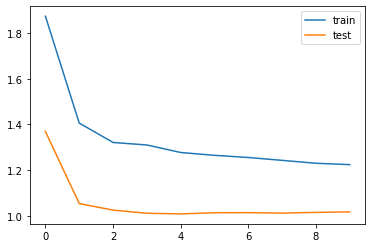

In [0]:

from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()



Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index


## Inference

Set up the inference for the encoder and decoder:


In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence



Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:


In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [0]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: somalia government said saturday investigating death malaysian shot dead african union allegedly fired humanitarian workers opened fire killing another journalist tv reporter somalia government said saturday statement police security forces immediately reached location incident started full investigation shocking action government said attempts reach au representative immediately successful saturday friday heading cover sponsored project help victims behalf malaysia national news agency interview malaysia prime minister said hero willing take risk provide extensive coverage missions help others many parts world said reporters without borders activist organization behalf journalist said friday somalia continued one dangerous countries world journalists often caught cross islamic al militia pro government forces long list journalists killed course work somalia africa country media personnel killed since reporters without borders said friday despite recent islamist group al violen